In [1]:
from process_library import *
import os 
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed


In [2]:
rng = np.random.RandomState(42)

# data loading 
path_to_parent_folder = "/".join( os.getcwd().split("/")[:-1] ) 
path_to_data = "data/pubchem_data_2023-12-05_350_samples.csv"
path = os.path.join(path_to_parent_folder,path_to_data)

df_all_data = pd.read_csv(path)

In [4]:
path_to_data = "data/transferability.xlsx"
path = os.path.join(path_to_parent_folder,path_to_data)

In [5]:
df_target = pd.read_excel(path, sheet_name="Sheet1")

In [6]:
df_selected_data = df_all_data [ df_all_data.substituent.isin(df_target.Substituent) == True] 

In [7]:
df_target[ df_target.Substituent.isin(df_all_data.substituent)== False]

,Substituent,Benzene,Pyrene,Pyridine,Butadiene,Butadiyne


In [8]:
df_target.columns.tolist()

['Substituent', 'Benzene', 'Pyrene', 'Pyridine', 'Butadiene', 'Butadiyne']

In [9]:
regression_models = load_regression_models()

In [29]:
models_to_test = ["Multi-layer Perceptron","Ridge","Random Forest"]

In [37]:
def get_data_separated2(dataframe, test_size=0.2, random_state=None,choice=0):
    if choice == 0 :
        target_feature = ['ΔVC -p'] #+ ΔVC-m,ΔVC -p
        features_to_drop = ['substituent','molecular_formula','Name','canonical_smiles','ΔVC-m','cid']

    elif choice == 1 : 
        target_feature = ['ΔVC-m']
        features_to_drop = ['substituent','molecular_formula','Name','canonical_smiles','ΔVC -p','cid']

    elif choice == 2 : 
        target_feature = ['ΔVC-m','ΔVC -p']
        features_to_drop = ['substituent','molecular_formula','Name','canonical_smiles','cid']

    else : 
        target_feature = ['Benzene', 'Pyrene', 'Pyridine', 'Butadiene', 'Butadiyne']
        features_to_drop = ['substituent','molecular_formula','Name','canonical_smiles','cid','ΔVC-m','ΔVC -p','molecular_formula_y','iupac_name',]



    # Assuming 'target_feature' is the dependent variable (y)
    y = dataframe[target_feature]
    X = dataframe.drop(columns=features_to_drop + target_feature)
    X =X.fillna(0)

    # Split into training and testing sets, excluding data_val
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test
    # # create the next sets , you split the temp data into halfs 
    # X_val, X_test, y_val, y_test = train_test_split(
    #     X_temp, y_temp, test_size=0.5, random_state=random_state
    # )

    # return X_train, X_val, X_test, y_train, y_val, y_test

def scaling_data2(X_train,X_test):

    scaler = StandardScaler()

    scaler.fit(X_train)
        
        # filename = '../models/scaler_for_all_features.sav'
        # pickle.dump(scaler, open(filename, 'wb'))
        
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    return scaled_train,scaled_test


def plot_the_r2_v2(y_true, X_pred , model): #(model,X_test,y_test,tag)
    y_true = y_true.to_numpy().ravel()
    y_pred = model.predict(X_pred)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red')
    plt.title('Real Values vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot Residuals
    residuals = y_true - y_pred.ravel()

    plt.subplot(1, 2, 2)
    plt.scatter(y_true, residuals, color='green')
    plt.axhline(y=0, linestyle='--', color='red')
    plt.title('Residual Plot')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

In [12]:
df_target.columns = ['substituent', 'Benzene', 'Pyrene', 'Pyridine', 'Butadiene', 'Butadiyne']

In [13]:
df = pd.merge(left=df_selected_data,right=df_target, on='substituent')

In [14]:
X_train, X_test, y_train, y_test = get_data_separated2(df,random_state=rng,choice=3)
feature_names_involved_in_training = X_train.columns

X_train, X_test = scaling_data2(X_train, X_test)
target_feature_name = "-".join(y_train.columns.to_list()).replace(" ","")

In [36]:
y_test

,Benzene,Pyrene,Pyridine,Butadiene,Butadiyne
8,8.3,8.5,7.5,11.3,10.0
16,-0.9,-1.3,-2.5,-0.3,-9.3
0,28.3,20.5,26.7,40.4,42.6
23,-9.0,-5.9,-11.1,-15.3,-13.8
11,3.5,2.1,2.2,5.9,-1.0


In [15]:
# for this case there is charates in the y-train and test that needs to be altered
for col in ['Benzene', 'Pyrene', 'Pyridine', 'Butadiene', 'Butadiyne']:
    y_train[col] = y_train[col].apply(lambda v: float(v.replace('−', '-')) if isinstance(v, str) else v)
    y_test[col]= y_test[col].apply(lambda v: float(v.replace('−', '-')) if isinstance(v, str) else v)

*************** Ridge ***************


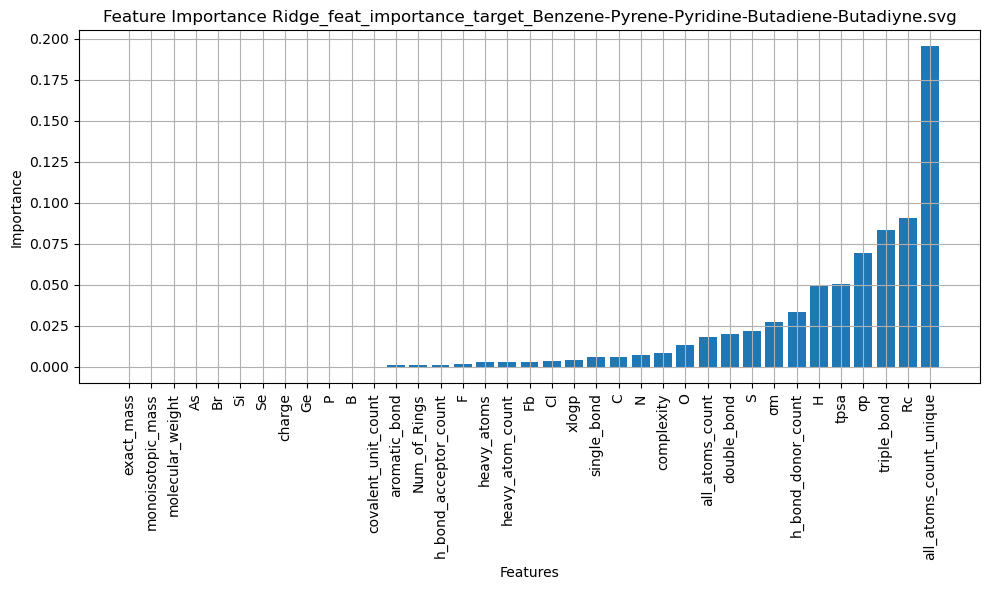

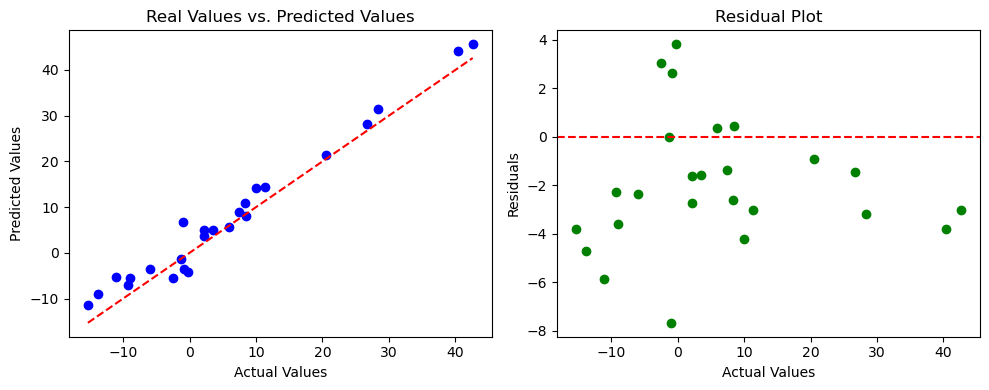

*************** Random Forest ***************


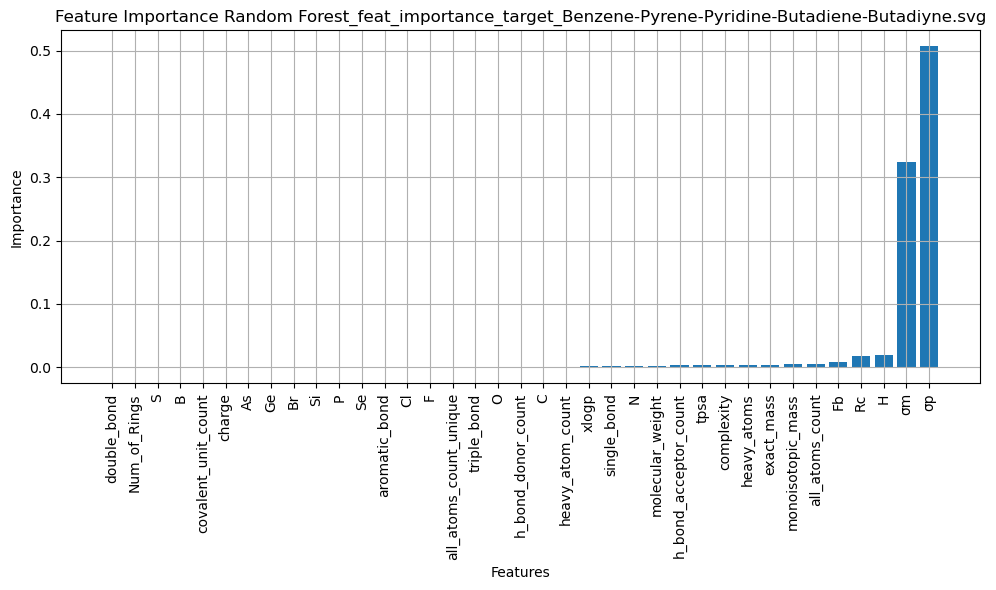

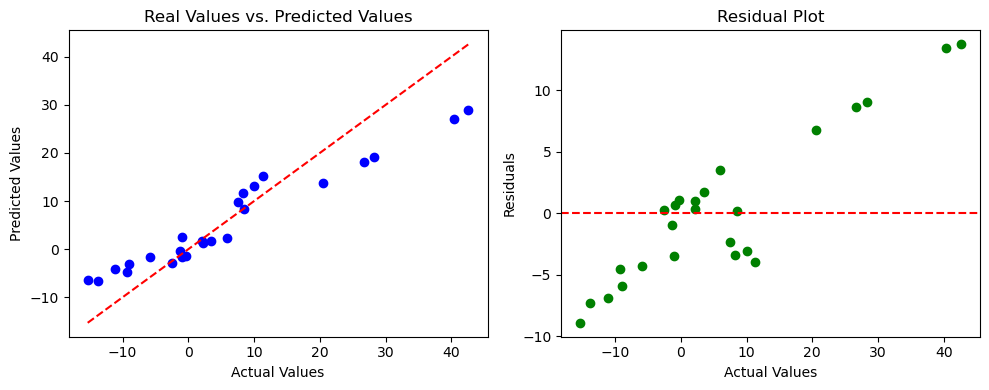

*************** Multi-layer Perceptron ***************


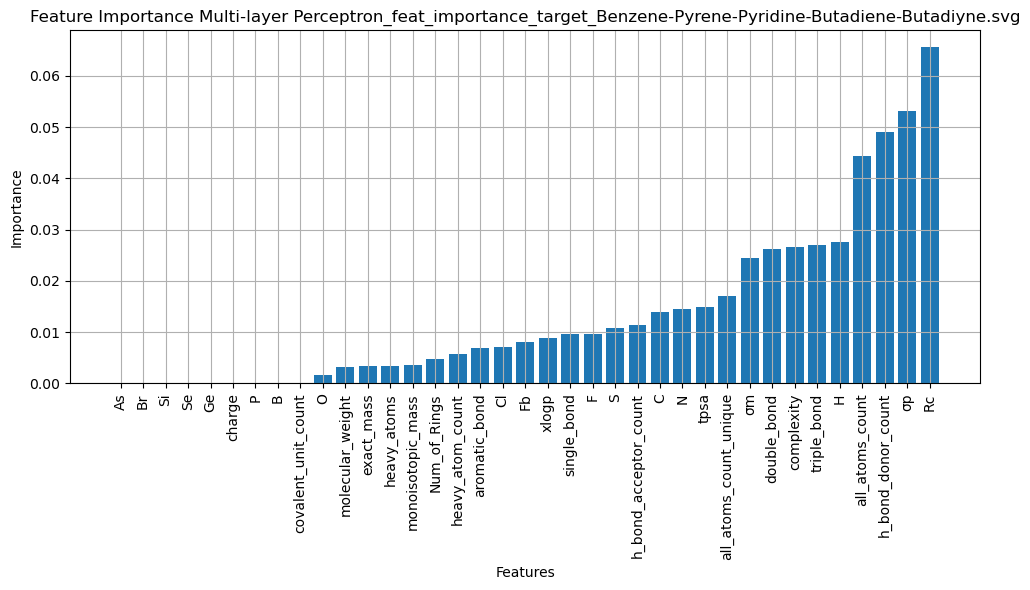

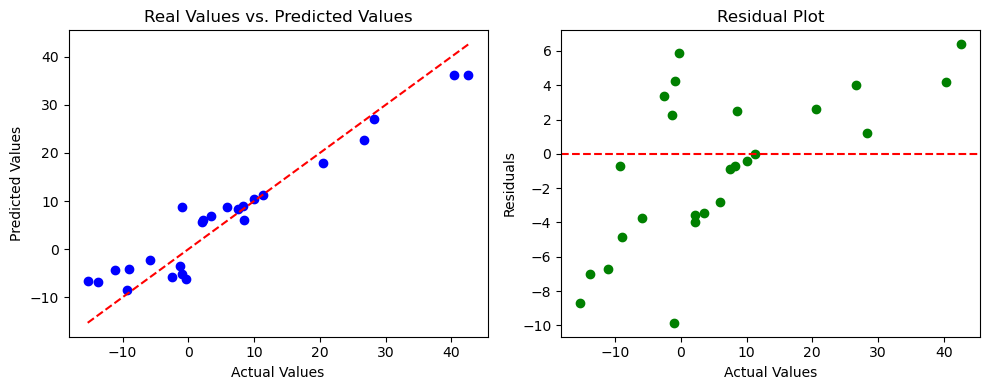

In [43]:
val_results_list = []
for name, model in regression_models.items():
    if name in models_to_test:
        print ('*'*15,name,'*'*15)
        model.fit(X_train, y_train)
        # y_pred = model.predict(X_test)
        # print ( y_pred )
        # print (y_test  )

        val_results_list.append ( save_metrics_results(model=model,X_test=X_test,y_test=y_test,tag=name) )

        feat_name, feat_importance = plot_features_using_permutation_importance( model=model,
                                                                                X_train=X_train, 
                                                                                y_train=y_train, 
                                                                                random_state=rng, 
                                                                                feature_names_ori=feature_names_involved_in_training,
                                                                                filename=f"{path_to_parent_folder}/figures/{name}_feat_importance_target_{target_feature_name}.svg")
        plot_the_r2_v2(model=model, y_true=y_test , X_pred=X_test)




In [44]:
val_results_df = pd.concat(val_results_list)

In [45]:
val_results_df.sort_values(by=["R^2", "MAE"],ascending=False)

,R^2,MAE,MSE,MAPE,MedAE
Ridge,0.954091,2.811984,10.824511,1.234263,2.868203
Multi-layer Perceptron,0.907616,3.757794,20.457474,1.851030,4.112030
Random Forest,0.840395,4.617880,35.961451,0.675285,3.049000
